# <center>DVH constraint optimization</center>

### This example demonstrates the use of portpy_photon to create down sampled influence matrix and optimize it with exact dvh constraints for benchmarking using MIP

1. Down sample influence matrix and create a plan without dvh constraint
2. Add exact DVH constraint (MIP formulation) and create a plan
3. Evaluate and compare the plans with and without dvh constraint

In [1]:
import sys
sys.path.append('..')

In [2]:
import portpy.photon as pp
import matplotlib.pyplot as plt
import cvxpy as cp

### 1) Create down sampled influence matrix and generate a plan without DVH constraint

In [3]:
# Create plan object
data_dir = r'../data'
data = pp.DataExplorer(data_dir=data_dir)
patient_id = 'Lung_Phantom_Patient_1'
data.patient_id = patient_id

# Load ct, structure and beams as an object
ct = pp.CT(data)
structs = pp.Structures(data)
beams = pp.Beams(data)

# create rinds based upon rind definition in optimization params
opt_params = data.load_config_opt_params(protocol_name='Lung_2Gy_30Fx')
structs.create_opt_structures(opt_params)

# load influence matrix based upon beams and structure set
inf_matrix = pp.InfluenceMatrix(ct=ct, structs=structs, beams=beams)

# create a influence matrix down sampled beamlets of width and height 10mm and down sampled voxels
voxel_down_sample_factors = [7, 7, 2]
opt_vox_xyz_res_mm = [ct_res * factor for ct_res, factor in zip(ct.get_ct_res_xyz_mm(), voxel_down_sample_factors)]
beamlet_down_sample_factor = 4
new_beamlet_width_mm = beams.get_finest_beamlet_width() * beamlet_down_sample_factor
new_beamlet_height_mm = beams.get_finest_beamlet_height() * beamlet_down_sample_factor

inf_matrix_dbv = inf_matrix.create_down_sample(beamlet_width_mm=new_beamlet_width_mm,
                                               beamlet_height_mm=new_beamlet_height_mm,
                                               opt_vox_xyz_res_mm=opt_vox_xyz_res_mm)

# load clinical criteria from the config files for which plan to be optimized
protocol_name = 'Lung_2Gy_30Fx'
clinical_criteria = pp.ClinicalCriteria(data, protocol_name)

my_plan = pp.Plan(ct, structs, beams, inf_matrix_dbv, clinical_criteria)

opt = pp.Optimization(my_plan, opt_params=opt_params)
opt.create_cvxpy_problem()
sol_no_dvh = opt.solve(solver='MOSEK', verbose='True')

creating rinds.. This step may take some time due to dilation
rinds created!!
Creating BEV..
Loading sparse influence matrix...
Done
reindexing voxels...
parsing influence matrix for beam 0
parsing influence matrix for beam 1
parsing influence matrix for beam 2
parsing influence matrix for beam 3
parsing influence matrix for beam 4
parsing influence matrix for beam 5
parsing influence matrix for beam 6
creating influence matrix for down sample voxels..
Objective Start
Objective done
Constraints Start
Structure ESOPHAGUS not available!
Structure ESOPHAGUS not available!
Constraints done
                                     CVXPY                                     
                                     v1.3.0                                    
(CVXPY) Jun 30 07:08:50 PM: Your problem has 1264 variables, 14 constraints, and 0 parameters.
(CVXPY) Jun 30 07:08:50 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jun 30 07:08:50 PM: (If you need to solve this problem multip

(CVXPY) Jun 30 07:08:53 PM: 19  2.1e-05  1.8e-04  8.5e-09  1.00e+00   3.201149828e+02   3.201149798e+02   1.1e-07  1.11  
(CVXPY) Jun 30 07:08:53 PM: 20  5.5e-06  4.6e-05  1.2e-09  1.00e+00   3.200977011e+02   3.200977003e+02   3.0e-08  1.14  
(CVXPY) Jun 30 07:08:53 PM: 21  1.7e-06  1.5e-05  2.1e-10  1.00e+00   3.200935409e+02   3.200935406e+02   9.6e-09  1.17  
(CVXPY) Jun 30 07:08:53 PM: 22  6.1e-07  5.2e-06  4.4e-11  9.95e-01   3.200923123e+02   3.200923121e+02   3.4e-09  1.20  
(CVXPY) Jun 30 07:08:53 PM: 23  3.6e-07  2.1e-06  1.2e-11  1.04e+00   3.200919742e+02   3.200919742e+02   1.4e-09  1.24  
(CVXPY) Jun 30 07:08:53 PM: 24  3.6e-07  2.1e-06  1.2e-11  1.01e+00   3.200919742e+02   3.200919742e+02   1.4e-09  1.39  
(CVXPY) Jun 30 07:08:53 PM: 25  2.5e-07  1.9e-06  1.0e-11  4.96e-01   3.200919322e+02   3.200919322e+02   1.3e-09  1.47  
(CVXPY) Jun 30 07:08:53 PM: 26  1.5e-07  7.3e-07  2.4e-12  8.84e-01   3.200917699e+02   3.200917699e+02   4.7e-10  1.55  
(CVXPY) Jun 30 07:08:54 

### 2) Add exact DVH constraint and generate a plan with DVH constraint

#### Model Formulation

Let us create a model formulation for dvh constraint of the form $V(d Gy) \leq v \% $


$
   \mbox{Minimize} \quad  w_o||A_{target}\mathbf{x}-pres||_{+} + w_u||A_{target}\mathbf{x}-pres||_{-} + w_{sm}(smoothness \space objective) + w_{oar}  ||A_{oar} \mathbf{x}||
$

$
\mbox{subject to}
$

$
\quad maximum(A_s\mathbf{x}) \leq {d_s}^{max}
$

$
\quad mean(A_s\mathbf{x}) \leq {d_s}^{mean}
$

$
\quad A_s\mathbf{x} \leq {d} + \mathbf{b}*M
$

$
\quad \sum_{i \in V_s}\mathbf{b}/n \leq v/100
$

$
\quad \mathbf{x} \geq 0
$

$
\quad \mathbf{b} \in \{0,1\}
$


where $w_o$ (overdose weight) = 10000 , $w_u$ (underdose weight) = 100000, $w_{sm}$ (smoothing weight) = 1000, $w_{oar}$ (oar weight) = 10, $s$ = structure index, $pres$ = prescription dose, $\mathbf{x}$ is beamlet intensity, $b$ is binary variable for the voxels, ${d_s}^{max}$ = maximum dose for structure s, ${d_s}^{mean}$ = mean dose for structure s, $A$ = influence matrix, $M$ (large number) = 1000

Smoothness objective is the total quadratic variation in beamlet intensity in x and y direction. It is given by,

$
smoothness \space objective = w_r\sum_{b\in{B}}\sum_{i\in{I_b}}(\mathbf{x}_i - \mathbf{x}_{R_i})^2 + w_l\sum_{b\in{B}}\sum_{i\in{I_b}}(\mathbf{x}_i - \mathbf{x}_{L_i})^2
$

where $w_r$ = 0.6, $w_l$=0.4, $R_i$ and $L_i$ = right and lower neigbour of beamlet i, $b$ = beam number, $I_b$ = beamlet indices of beam $b$

In [4]:
# Add a dvh constraint V(10Gy) <= 15% for CORD as shown below
dvh_org = 'CORD'
dose_gy =  10
limit_volume_perc = 10

# extract data for dvh constraint
A = inf_matrix_dbv.A # down sample influence matrix
x = opt.vars['x'] # optimization variable
M = 50 # set Big M for dvh constraint
frac = my_plan.structures.get_fraction_of_vol_in_calc_box(dvh_org) # get fraction of dvh organ volume inside dose calculation box


# Create binary variable for dvh constraint
b_dvh = cp.Variable(
    len(inf_matrix_dbv.get_opt_voxels_idx('CORD')),
    boolean=True)

# Add dvh constraint
opt.constraints += [
    A[inf_matrix_dbv.get_opt_voxels_idx(dvh_org), :] @ x <= dose_gy / my_plan.get_num_of_fractions()
    + b_dvh * M]
opt.constraints += [b_dvh @ inf_matrix_dbv.get_opt_voxels_volume_cc(dvh_org) <= (limit_volume_perc / frac) / 100 * sum(
    inf_matrix_dbv.get_opt_voxels_volume_cc(dvh_org))]

In [5]:
sol_dvh = opt.solve(solver='MOSEK', verbose='True')

                                     CVXPY                                     
                                     v1.3.0                                    
(CVXPY) Jun 30 07:08:54 PM: Your problem has 1375 variables, 16 constraints, and 0 parameters.
(CVXPY) Jun 30 07:08:54 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jun 30 07:08:54 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jun 30 07:08:54 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jun 30 07:08:54 PM: Compiling problem (target solver=MOSEK).
(CVXPY) Jun 30 07:08:54 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffin

### 3) Visualize the DVH of the plans with and without DVH constraint

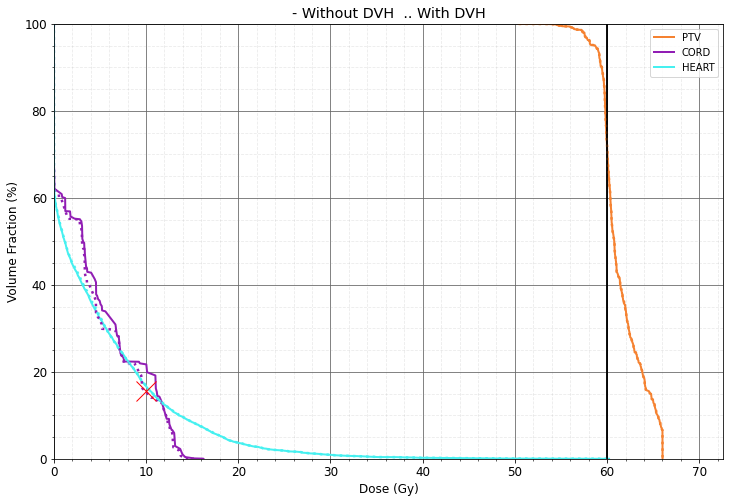

Done!


In [8]:
fig, ax = plt.subplots(figsize=(12, 8))
struct_names = ['PTV', 'ESOPHAGUS', 'HEART', 'CORD']
ax = pp.Visualization.plot_dvh(my_plan, sol=sol_no_dvh, struct_names=struct_names, style='solid', ax=ax)
ax = pp.Visualization.plot_dvh(my_plan, sol=sol_dvh, struct_names=struct_names, style='dotted', ax=ax)
ax.plot(dose_gy, limit_volume_perc/frac, marker='x', color='red', markersize=20)
ax.set_title('- Without DVH  .. With DVH')
plt.show()
print('Done!')